In [31]:
import sys
import tqdm
import torch
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from collections import defaultdict

#sys.path.append("../src")
from sharpness import compute_all_metrics
from sharpness.transforms import GaussianBlur, GaussianNoise, AdjustBrightness

In [32]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

In [33]:
data_path = "../data/synthetic_holograms.nc"

In [34]:
f = xr.open_dataset(data_path)

<Figure size 700x432.624 with 0 Axes>

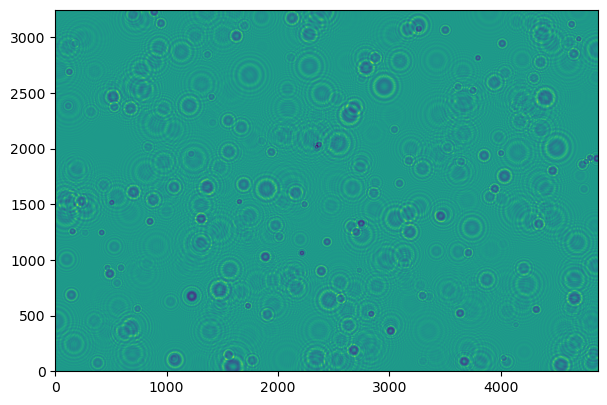

In [35]:
### Slow -- loads all data then takes the indexed example
image = f["image"].isel(hologram_number=0).values

fontsize = 10
single_column_width = 7
plt.figure(figsize = (single_column_width, single_column_width / 1.61803398875))
fig, ax = plt.subplots(1, 1, figsize=(single_column_width, single_column_width * 1.61803398875), 
                         gridspec_kw={'hspace': 0.0, 'wspace': 0.2})
ax.imshow(image.transpose(1,0), origin ='lower')

In [36]:
class WavePropagator(object):

    def __init__(self,
                 data_path,
                 n_bins=1000,
                 tile_size=512,
                 step_size=128,
                 marker_size=10,
                 transform_mode=None,
                 device="cpu"):

        self.h_ds = xr.open_dataset(data_path)

        if 'zMin' in self.h_ds.attrs:
            self.zMin = self.h_ds.attrs['zMin']  # minimum z in sample volume
            self.zMax = self.h_ds.attrs['zMax']
        else:  # some of the raw data does not have this parameter
            # should warn the user here through the logger
            self.zMin = 0.014
            self.zMax = 0.158 #15.8 - 1.4 / (1000)

        self.n_bins = n_bins
        self.z_bins = np.linspace(
            self.zMin, self.zMax, n_bins+1)*1e6  # histogram bin edges
        self.z_centers = self.z_bins[:-1] + 0.5 * \
            np.diff(self.z_bins)  # histogram bin centers

        self.tile_size = tile_size  # size of tiled images in pixels
        self.step_size = step_size  # amount that we shift the tile to make a new tile
        # UNET gaussian marker width (standard deviation) in um
        self.marker_size = marker_size
        self.device = device

        # step_size is not allowed be be larger than the tile_size
        assert self.tile_size >= self.step_size

        self.dx = self.h_ds.attrs['dx']      # horizontal resolution
        self.dy = self.h_ds.attrs['dy']      # vertical resolution
        self.Nx = int(self.h_ds.attrs['Nx'])  # number of horizontal pixels
        self.Ny = int(self.h_ds.attrs['Ny'])  # number of vertical pixels
        self.lam = self.h_ds.attrs['lambda']  # wavelength
        self.image_norm = 255.0
        self.transform_mode = transform_mode
        self.x_arr = np.arange(-self.Nx//2, self.Nx//2)*self.dx
        self.y_arr = np.arange(-self.Ny//2, self.Ny//2)*self.dy

        self.tile_x_bins = np.arange(-self.Nx//2,
                                     self.Nx//2, self.step_size)*self.dx*1e6
        self.tile_y_bins = np.arange(-self.Ny//2,
                                     self.Ny//2, self.step_size)*self.dy*1e6

        self.fx = torch.fft.fftfreq(
            self.Nx, self.dx, device=self.device).unsqueeze(0).unsqueeze(2)
        self.fy = torch.fft.fftfreq(
            self.Ny, self.dy, device=self.device).unsqueeze(0).unsqueeze(1)

    def torch_holo_set(self,
                       Ein: torch.tensor,
                       z_tnsr: torch.tensor):
        """
        Propagates an electric field a distance z
        Ein complex torch.tensor
        - input electric field

        fx:real torch.tensor
        - x frequency axis (3D, setup to broadcast)

        fy: real torch.tensor
        - y frequency axis (3D, setup to broadcast)

        z_tnsr: torch.tensor
        - tensor of distances to propagate the wave Ein
            expected to have dims (Nz,1,1) where Nz is the number of z
            dimensions

        lam: float
        - wavelength

        returns: complex torch.tensor with dims (Nz,fy,fx)

        Note the torch.fft library uses dtype=torch.complex64
        This may be an issue for GPU implementation

        """

        if self.transform_mode == "standard":
            Ein = Ein.float()
            Ein -= torch.mean(Ein)
            Ein /= torch.std(Ein)

        elif self.transform_mode == "min-max":
            Ein = Ein.float()
            Ein -= torch.min(Ein)
            Ein /= torch.max(Ein)

        Etfft = torch.fft.fft2(Ein)
        Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/self.lam *
                                torch.sqrt(1-self.lam**2*(self.fx**2+self.fy**2)))

        # It might be helpful if we could omit this step.  It would save an inverse fft.
        Eout = torch.fft.ifft2(Eofft)

        return Eout

In [37]:
propagator = WavePropagator(data_path, device = device)

In [38]:
noise = True

In [27]:
subselection = subselection = propagator.z_centers[::100]
size = 128

In [29]:
image = f["image"].isel(hologram_number=0).values
bulk_metrics = defaultdict(list)

#subselection = propagator.z_centers[::10]
frames = np.zeros((len(propagator.z_centers), image.shape[0], image.shape[1]))
for k, z in tqdm.tqdm(enumerate(subselection), total = len(subselection)):
    # prop
    zp_im = propagator.torch_holo_set(
        torch.from_numpy(image).to(device),
        torch.FloatTensor([z*1e-6]).to(device)
    ).squeeze(0) # this tensor is complex! 
    # ABS
    prop_im = torch.abs(zp_im).cpu().numpy()
    # Phase
    #prop_phase = torch.angle(zp_im).cpu().numpy()
    frames[k] = prop_im
    
    if noise:
        prop_im -= prop_im.min()
        prop_im /= prop_im.max()
            
        # Apply the GaussianBlur transformation to the image
        prop_im = GaussianBlur(rate=1, sigma=2.1252219359742823)(prop_im)

        # Apply the GaussianNoise transformation to the image
        prop_im = GaussianNoise(rate=1, noise=0.3258530643453389)(prop_im)

        # Apply the Brightness adjustment transformation to the image
        prop_im = AdjustBrightness(rate=1, brightness=1.269735791766263)(prop_im)
    
    grad_metrics = compute_all_metrics(image[:size] / 255., prop_im[:size] / 255.)
    for m, v in grad_metrics.items():
        bulk_metrics[m].append(v)

100%|██████████| 10/10 [02:01<00:00, 12.10s/it]


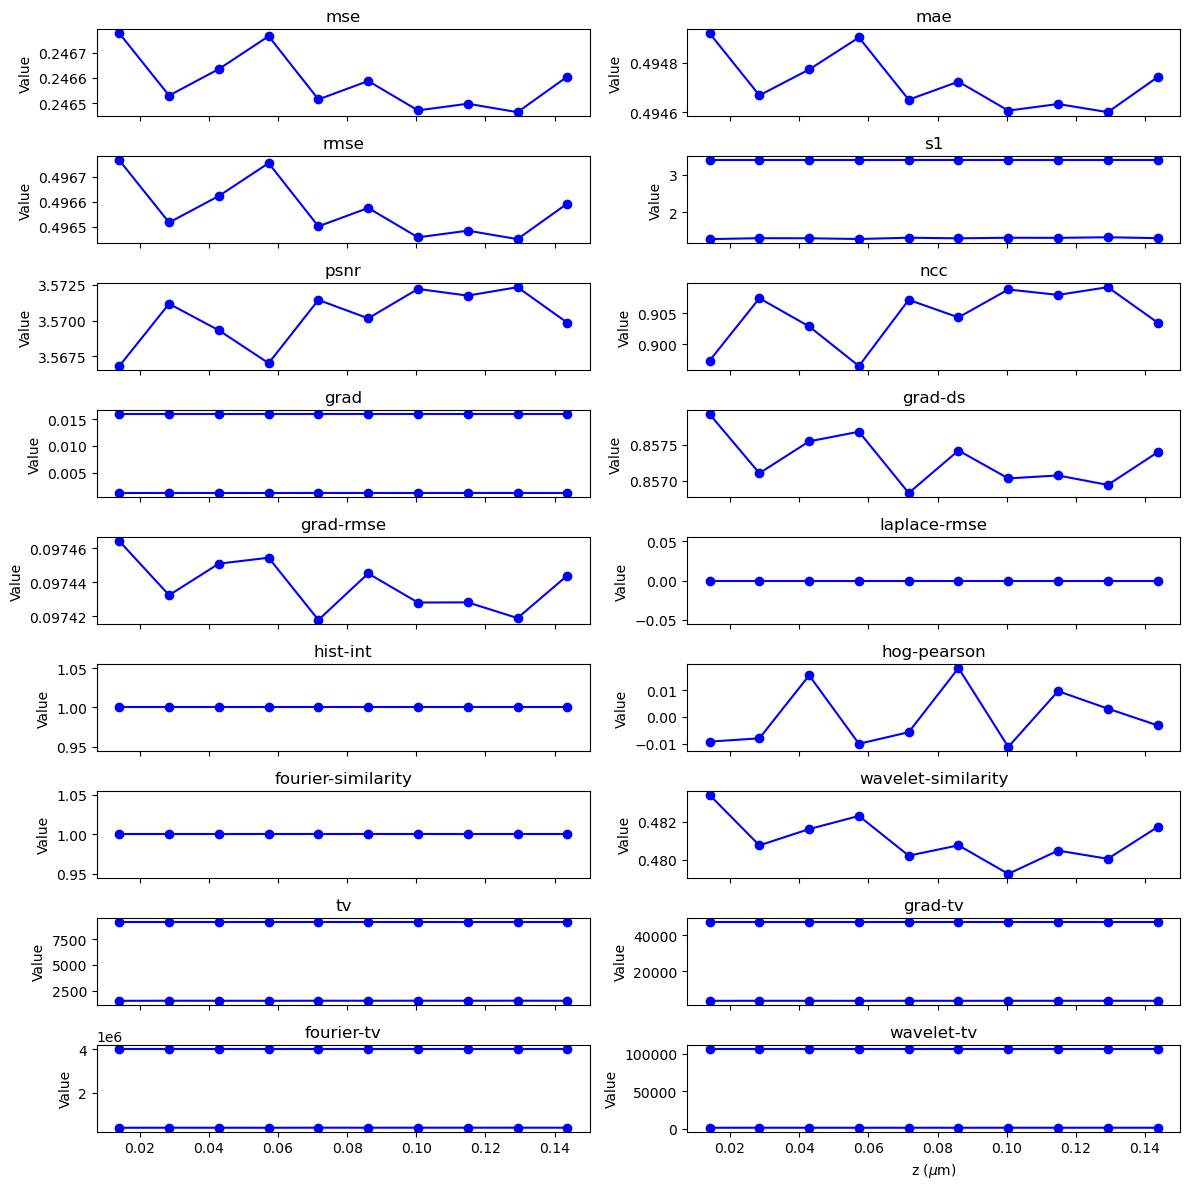

In [30]:
# Create subplots with two columns
num_metrics = len(bulk_metrics)
num_cols = 2  # Number of columns
num_rows = (num_metrics + 1) // 2  # Calculate the number of rows needed

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 12), sharex = "col")

z_centers = [1e-6 * xx for xx in subselection]
# Loop over metric keys and values
for i, (metric_key, metric_values) in enumerate(bulk_metrics.items()):
    row = i // num_cols
    col = i % num_cols

    axs[row, col].plot(z_centers, metric_values, marker='o', linestyle='-', color='b')
    axs[row, col].set_title(metric_key)
    axs[row, col].set_ylabel('Value')
axs[row, col].set_xlabel(r'z ($\mu$m)')

# Remove empty subplots (if any)
if num_metrics % 2 == 1:
    fig.delaxes(axs[-1, -1])

plt.tight_layout()
plt.show()